# Autoregressive Integrated Moving Average (ARIMA)

## 0. Imports

### 0.1. Libraries

In [1]:
# Data Manipulation
import pandas               as pd
import numpy                as np

from itertools              import product

# Data Visualisation
import seaborn              as sns
import matplotlib           as mpl
import matplotlib.pyplot    as plt

# Statsmodels
from statsmodels.tsa.seasonal           import seasonal_decompose
from statsmodels.tsa.stattools          import adfuller, kpss
from statsmodels.graphics.tsaplots      import plot_acf, plot_pacf


# Models
from pmdarima.arima                         import auto_arima
from statsmodels.tsa.arima.model            import ARIMA
from statsmodels.tsa.statespace.sarimax     import SARIMAX

# Scikit-learn
from sklearn.metrics        import mean_squared_error

# Other
import warnings
from tqdm                   import tqdm_notebook

### 0.2. Settings

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Visualization Settings
%matplotlib inline

mpl.style.use('ggplot') 

mpl.rcParams['figure.titlesize']    = 24
mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

### 0.3. Functions

In [3]:
def df_shape(df):
    """
    Summary: The function prints the number of rows and columns of a given DataFrame.
    Args: df: the DataFrame we want to know more about.
    Returns: text: text indicating the number of rows and columns of the DataFrame.
    """
    print('Number of rows: {}'.format(df.shape[0]))
    print('Number of columns: {}'.format(df.shape[1]))

    return None

def set_day_to_first(date):
    """
    Summary: This function sets the first day of the month for a given date.
    Args:
        date: the date we want to set the first day of the month.
    Returns: date with the first day of the month.
    """
    if date.day == 1:
        return date
    if date.day == 2:
        return date.replace(day=1)
        
    return date

def set_image(fig, title, xlabel, ylabel, legend=None, xrotation=0, yrotation=0):
    """
    Summary: This function sets the image configuration for a Matplotlib plot.
    Args:
        fig: the figure object.
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.
    Returns: figure with the image configuration.
    """
    # Customizing
    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=xrotation)
    plt.yticks(rotation=yrotation)
    plt.tick_params(left=False, bottom=False)

    if legend is not None:
        plt.legend([legend], loc='best')
    else:
        plt.legend(loc='best')

    return fig;

### 0.4. Datasets

In [4]:
df_jj = pd.read_csv('../data//raw/jj.csv')

## 1. Data Description

### 1.1. Data Dimensions

In [5]:
df_shape(df_jj)

df_jj.head()

Number of rows: 84
Number of columns: 2


,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [6]:
df_jj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


## 2. Preprocessing 

In [7]:
# Copying the data
df_jjq = df_jj.copy()

# Setting 'date' as datetime
df_jjq['date'] = pd.to_datetime(df_jjq['date'], format='%Y-%m-%d')

# Setting the first day of the month
df_jjq['date'] = df_jjq['date'].apply(set_day_to_first)

# Setting 'date' as index
df_jjq.set_index('date', inplace=True)

# Setting frequency
df_jjq.index.freq = 'QS'

In [8]:
df_jjq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Freq: QS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


## 3. Exploratory Data Analysis

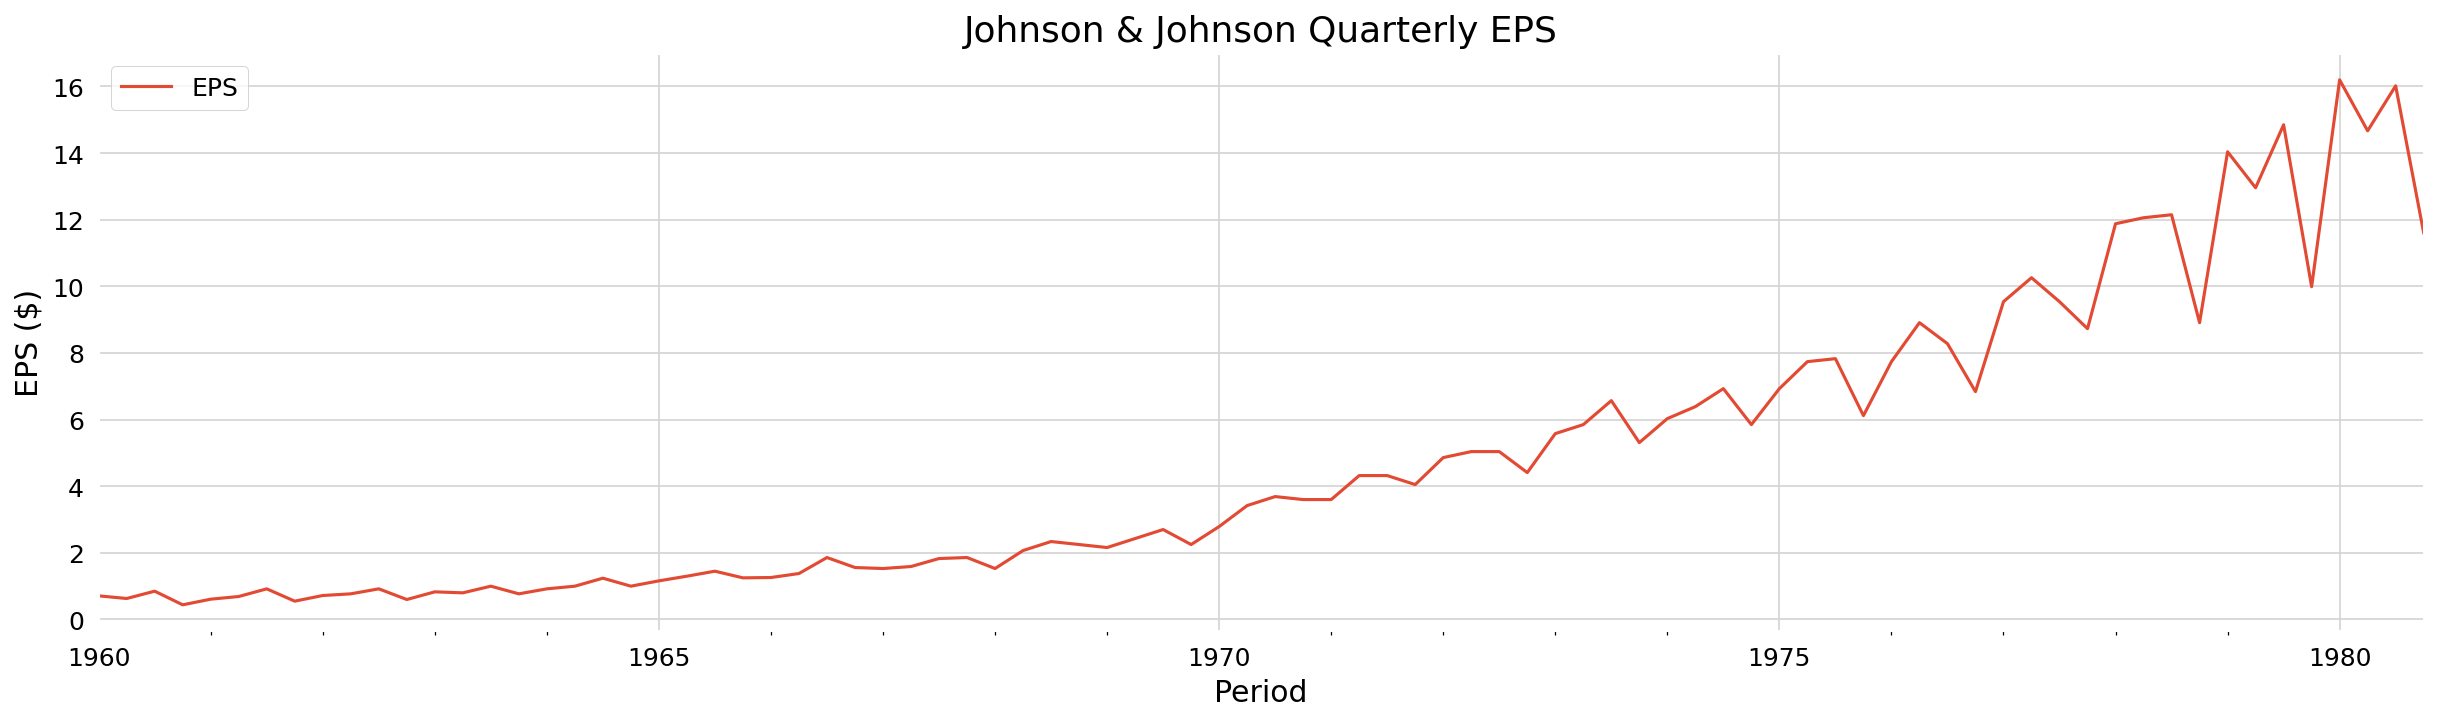

In [9]:
# Plot
fig = df_jjq.plot()

# Customizing
fig = set_image(fig, 'Johnson & Johnson Quarterly EPS', 'Period', 'EPS ($)', 'EPS')

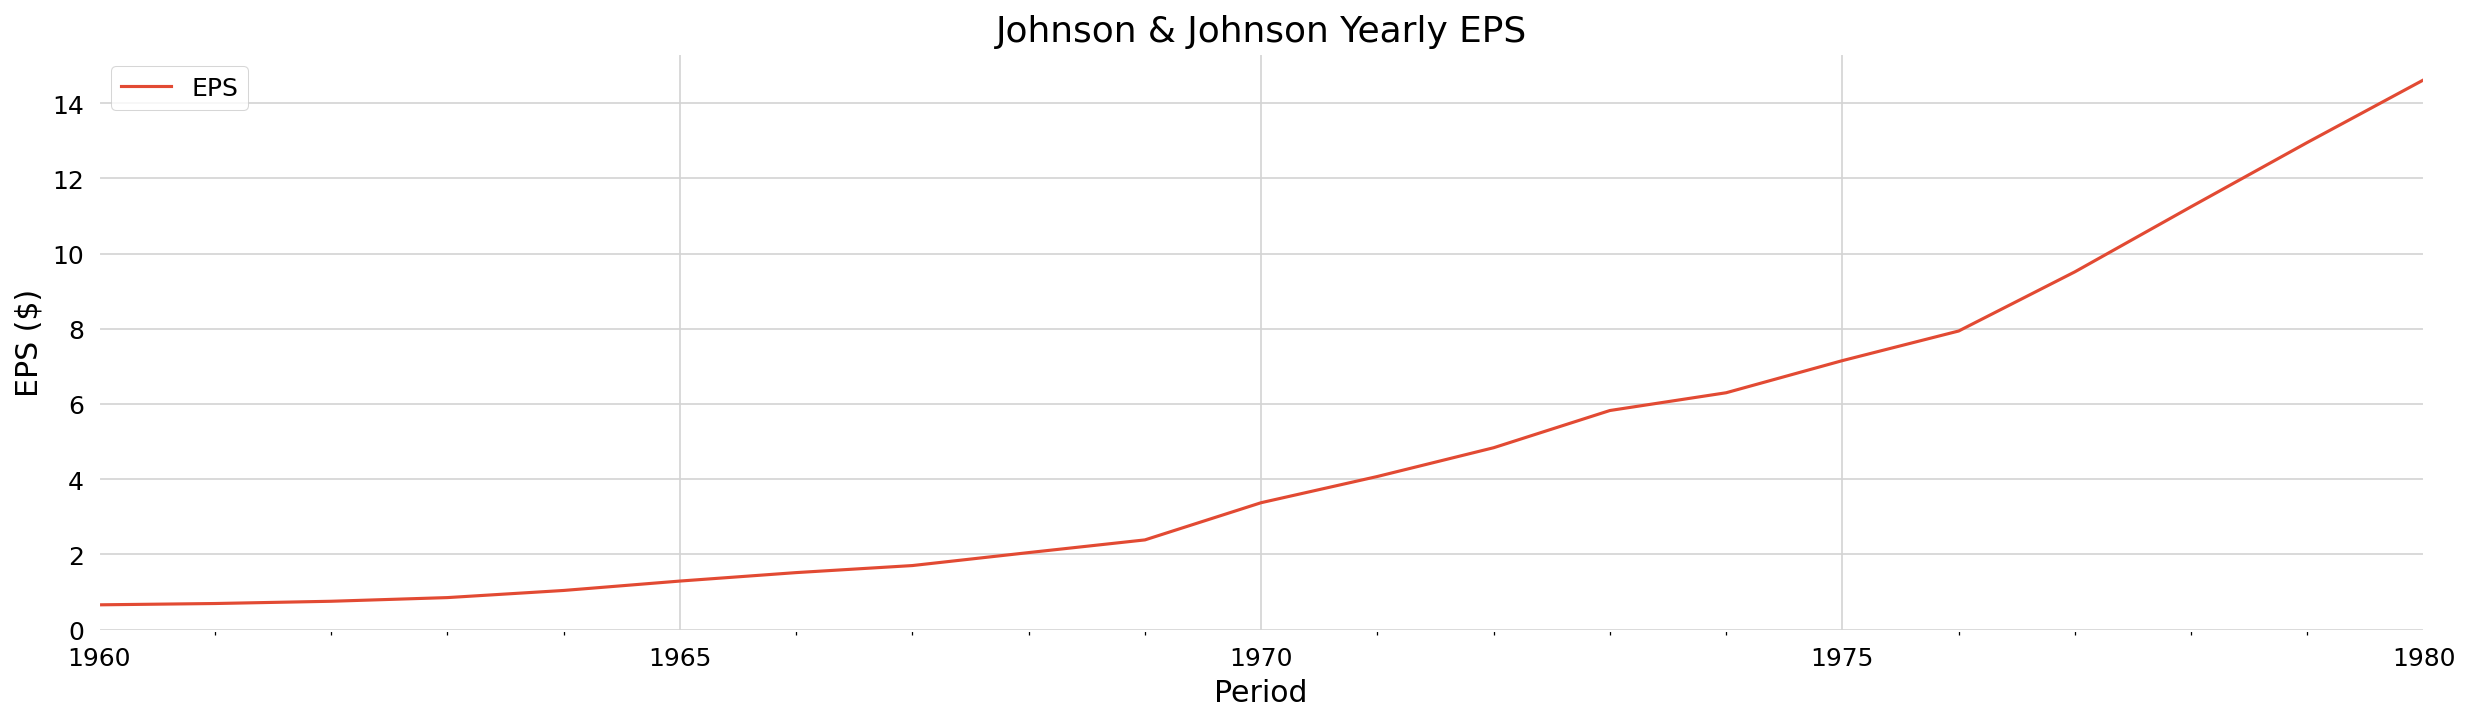

In [10]:
# Resample
df_jjy = df_jjq.resample('Y').mean()

# Plot
fig = df_jjy.plot()

# Customizing
fig = set_image(fig, 'Johnson & Johnson Yearly EPS', 'Period', 'EPS ($)', 'EPS')

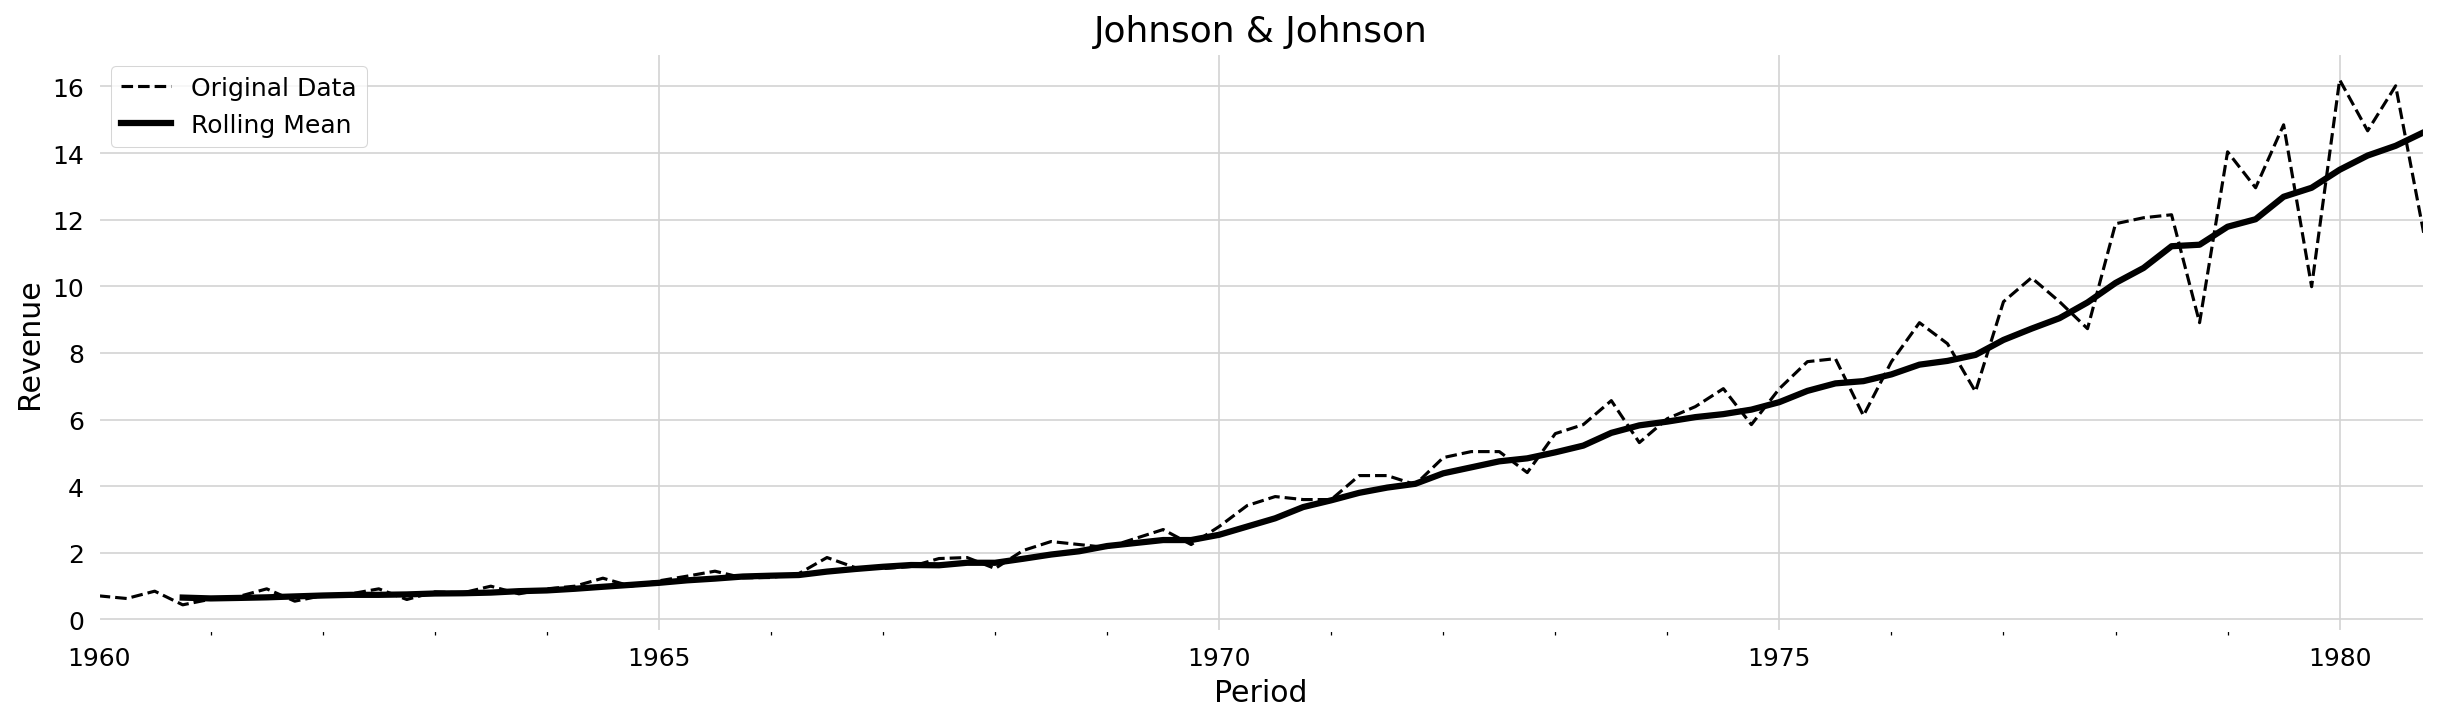

In [11]:
# Applying rolling mean of 4 quarters
rolling_mean = df_jjq.rolling(4).mean()

# Creating a plot
ax = df_jjq.plot(style='k--')
rolling_mean.plot(style='k-', linewidth=3, ax=ax)

# Customizing the plot
ax = set_image(ax, 'Johnson & Johnson', 'Period', 'Revenue')
ax.legend(['Original Data', 'Rolling Mean']);

## 3. Decomposing the time series

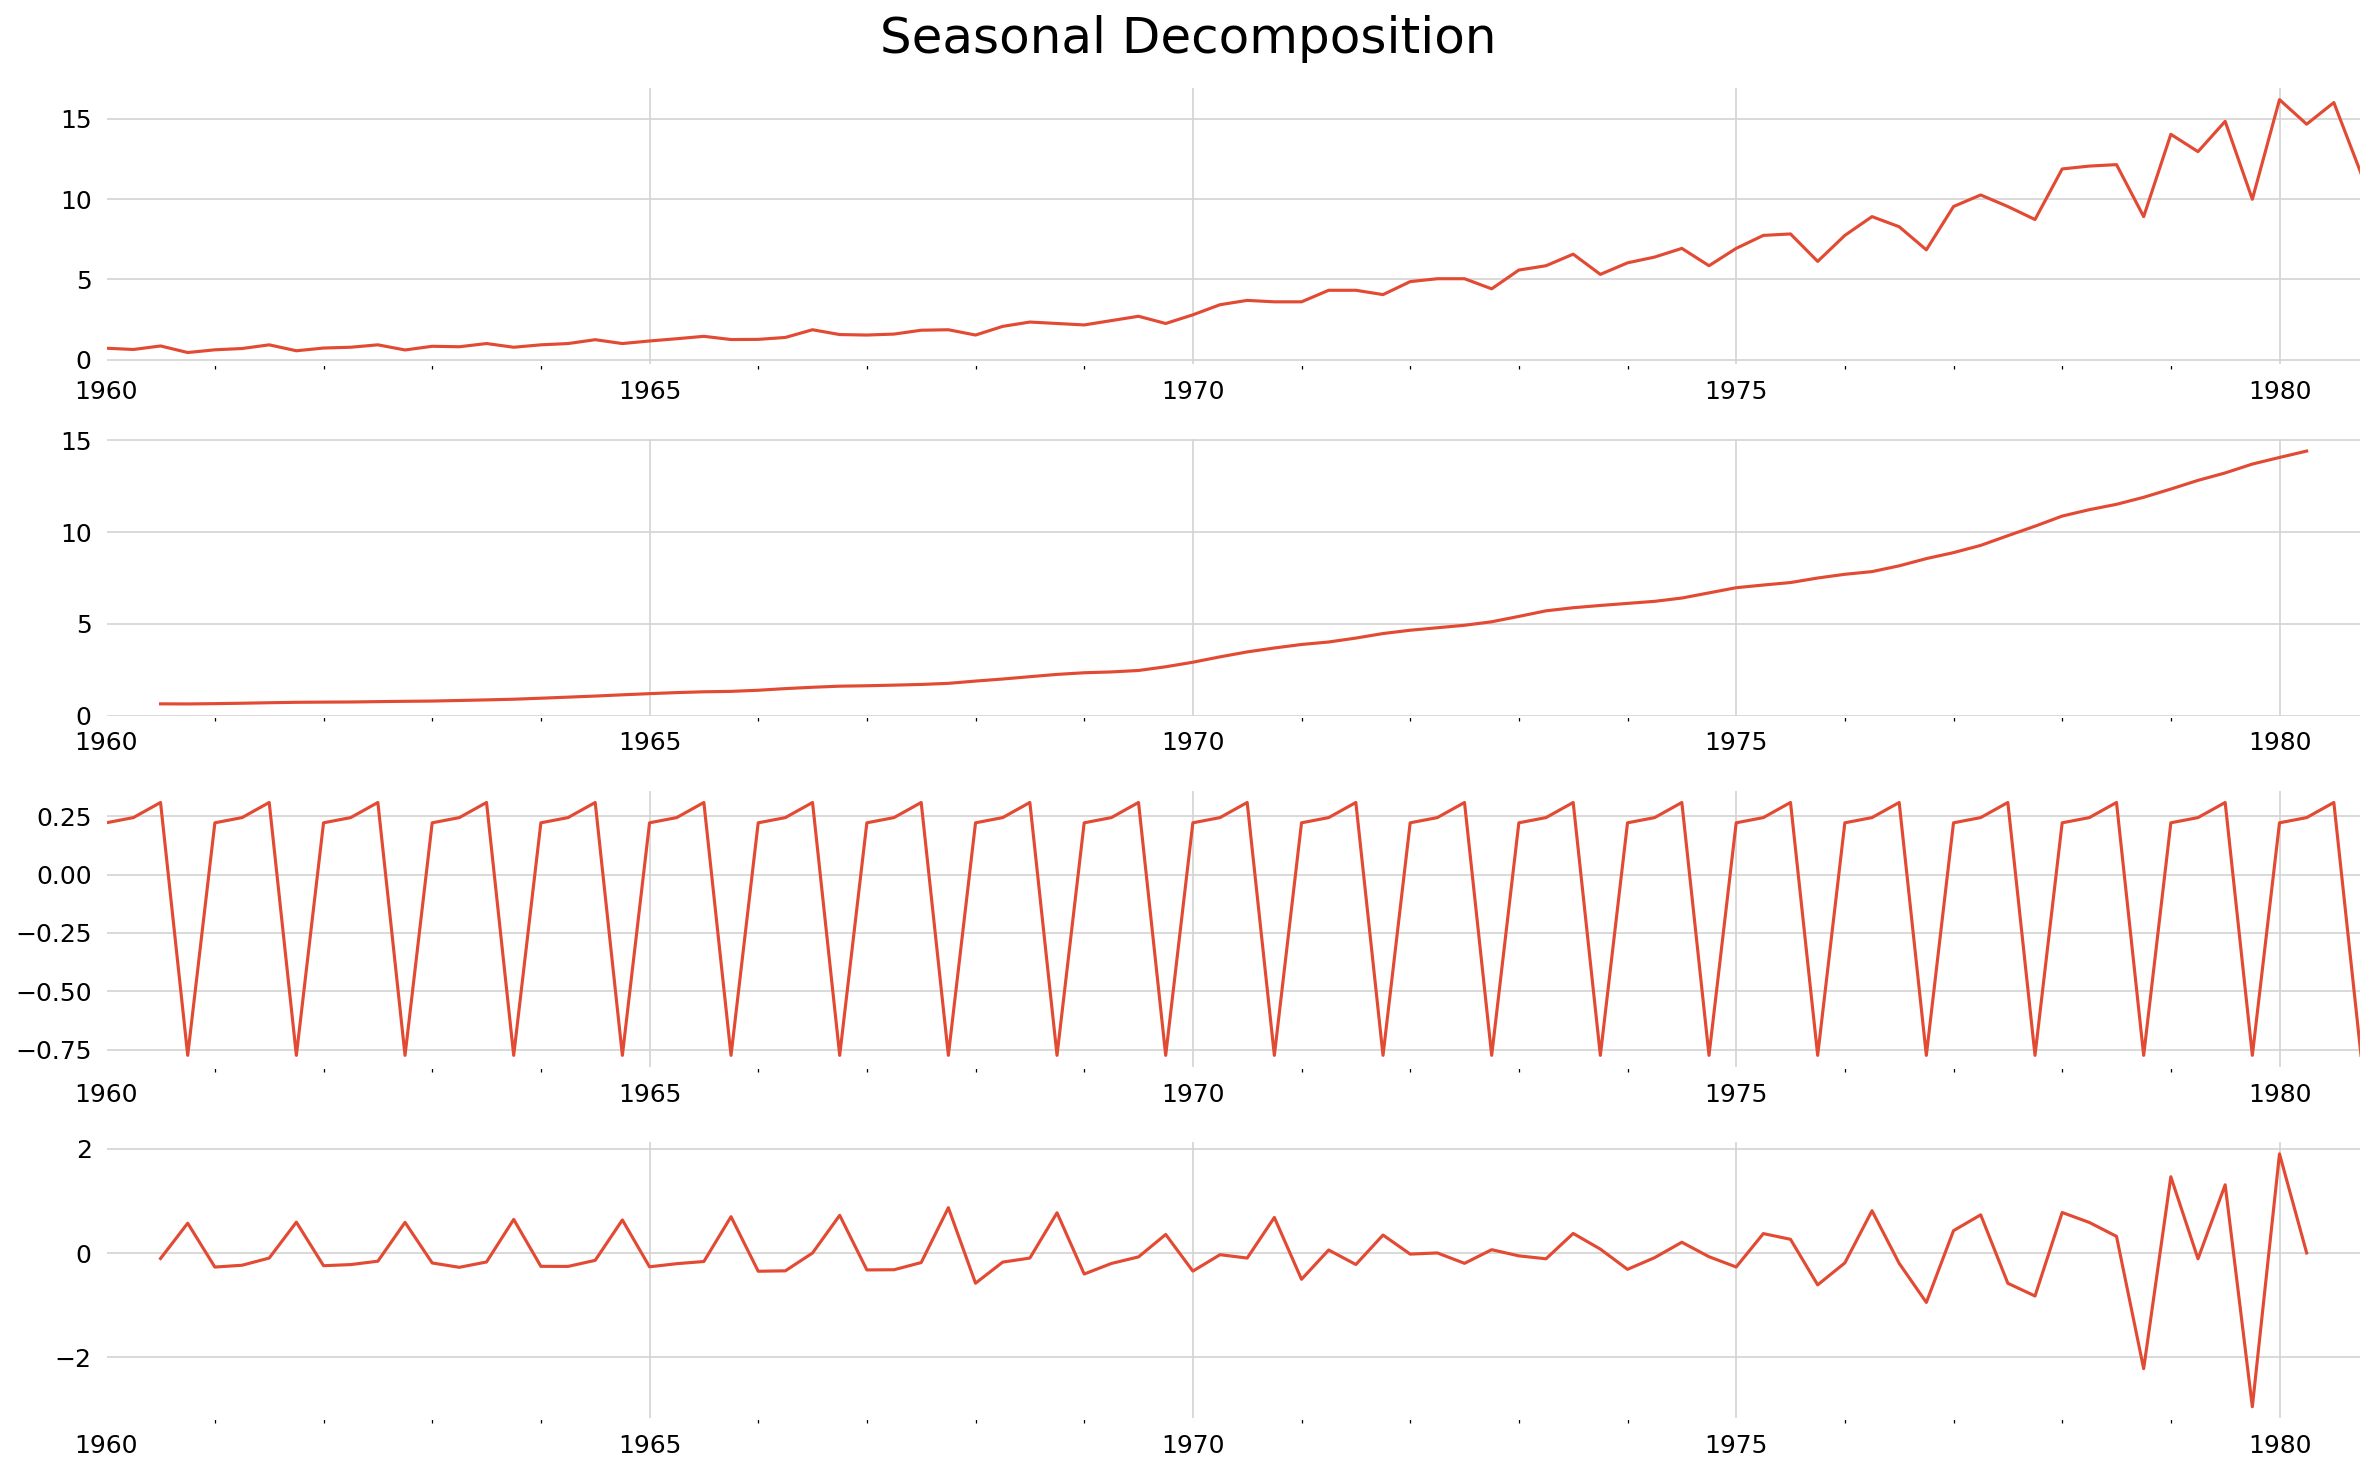

In [12]:
# Decompose the data into trend, seasonal and residual components
DecomposeResult = seasonal_decompose(
    df_jjq, 
    model='additive')

# Create a figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10))

DecomposeResult.observed.plot(ax=ax1)
DecomposeResult.trend.plot(ax=ax2)
DecomposeResult.seasonal.plot(ax=ax3)
DecomposeResult.resid.plot(ax=ax4)

# Main title
plt.suptitle('Seasonal Decomposition')

# Customizing
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(left=False, bottom=False)
    ax.set_xlabel('')

# Adjust layout
plt.tight_layout()

## 4. Verifying stationarity

In [13]:
# Augmented Dickey-Fuller test on the original data
result = adfuller(df_jjq)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


In [14]:
# ADF test on the differenciated data
result = adfuller(df_jjq.diff().dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.407409763638043
p-value: 0.9088542416911309


In [15]:
# ADF test on the logarithmic differenciated data
result = adfuller(np.log(df_jjq).diff().dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.317043945811833
p-value: 0.0004149731404440715


In [16]:
# KPSS test on original data
result = kpss(df_jjq)
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

KPSS Statistic: 1.3634938602266962
p-value: 0.01


In [17]:
# KPSS test on differenciated data
result = kpss(df_jjq.diff().dropna())
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

KPSS Statistic: 0.2213962709674728
p-value: 0.1


In [18]:
# KPSS test on logarithmic differenciated data
result = kpss(np.log(df_jjq).diff().dropna())
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

KPSS Statistic: 0.1482464765258106
p-value: 0.1


### 4.1.

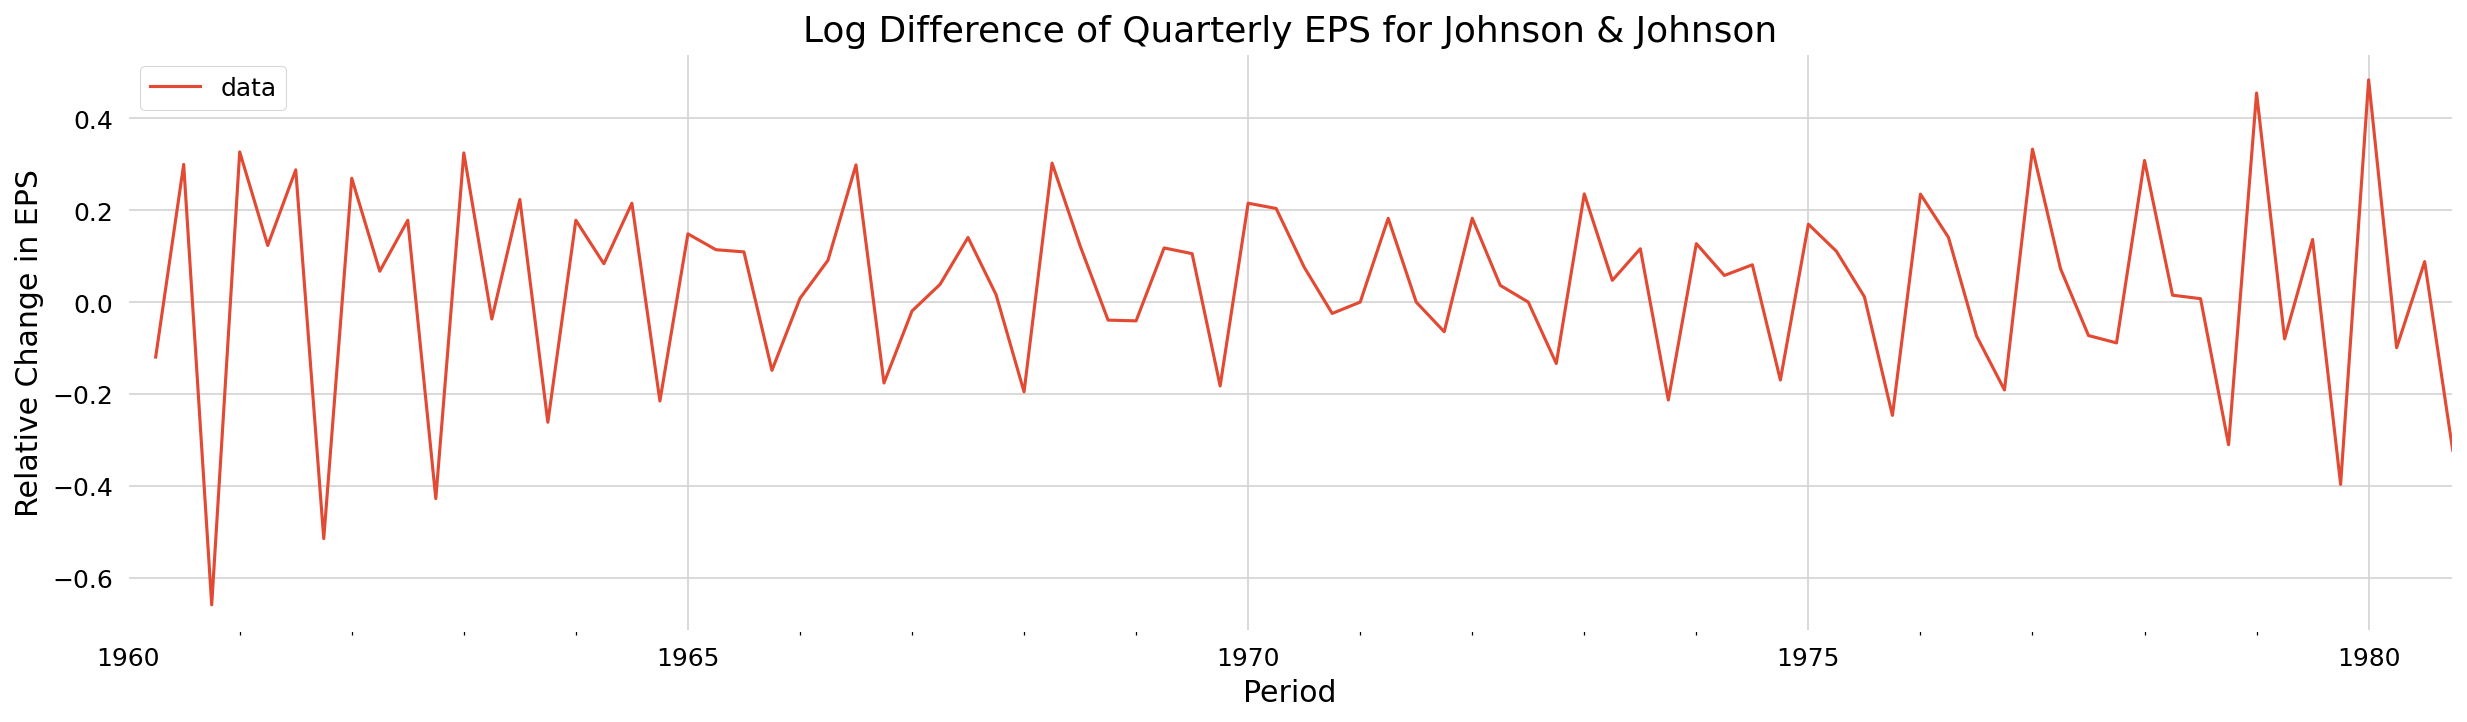

In [19]:
# Log Difference of Quarterly EPS for Johnson & Johnson"
fig = np.log(df_jjq).diff().plot()

fig = set_image(fig, 'Log Difference of Quarterly EPS for Johnson & Johnson', 'Period', 'Relative Change in EPS')

## 5. Autocorrelation and Partial Autocorrelation Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


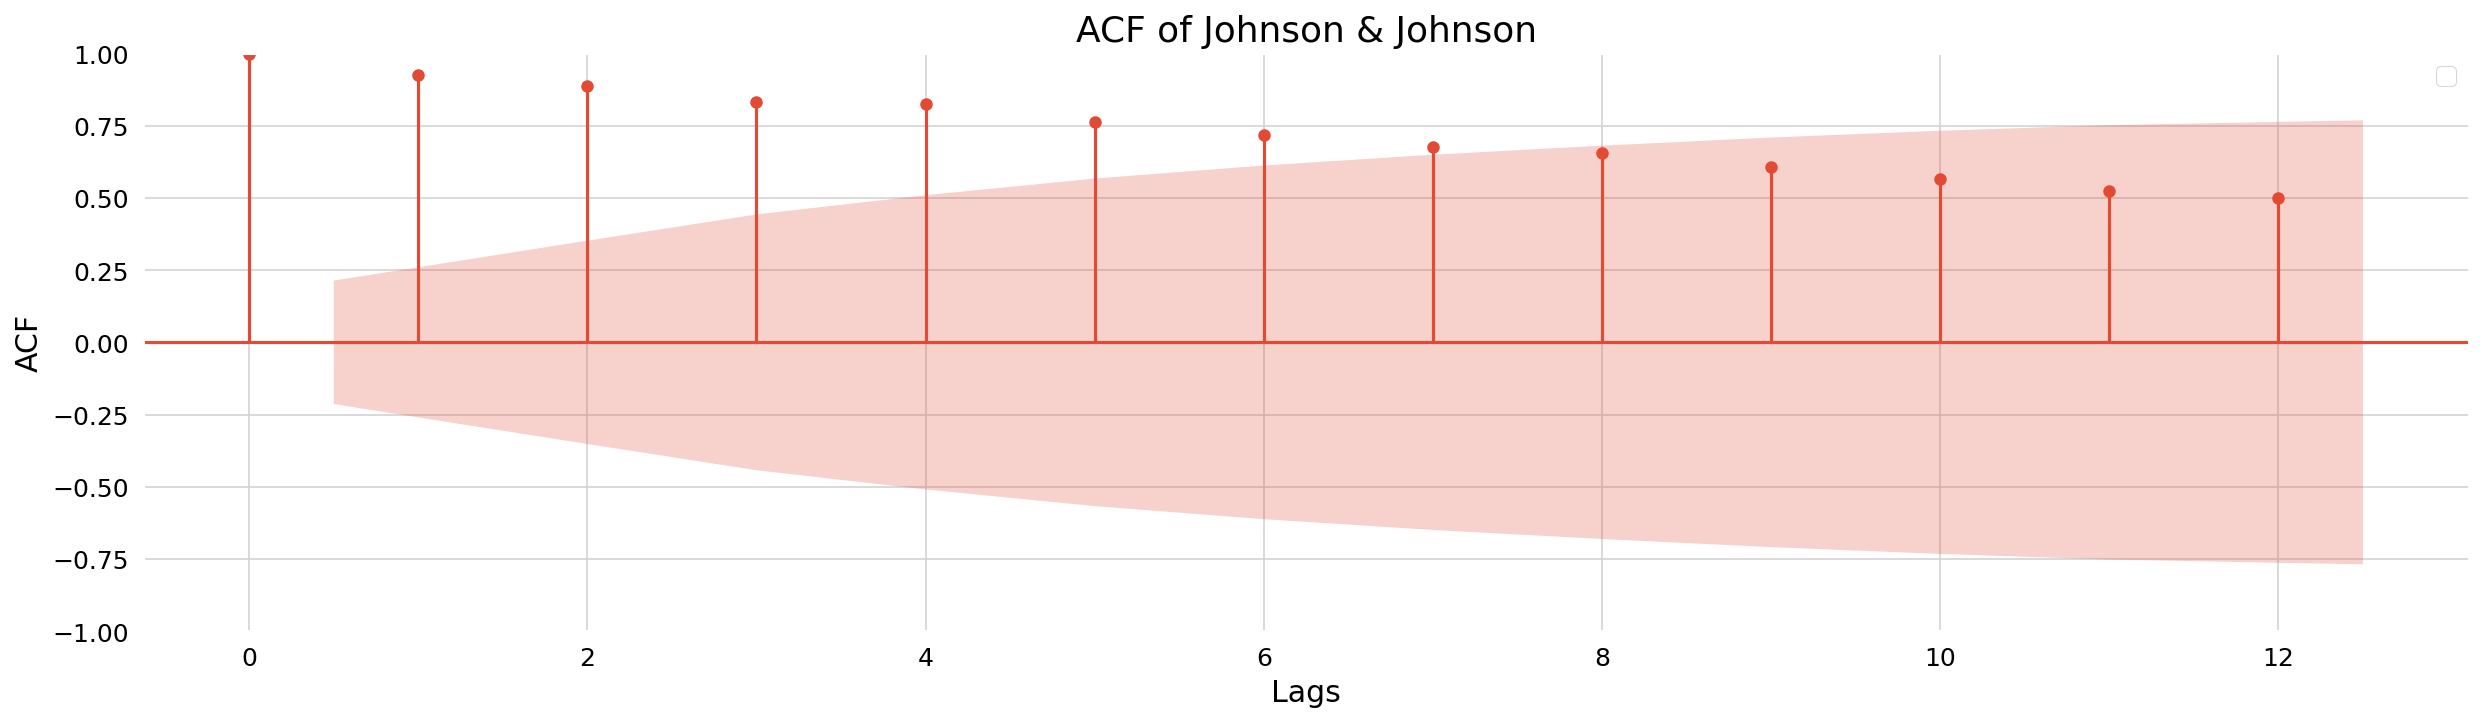

In [20]:
# Plotting ACF
fig = plot_acf(df_jjq, lags=12)

fig = set_image(fig, 'ACF of Johnson & Johnson', 'Lags', 'ACF', None)

## 6. ARIMA

In [21]:
fit_arima = auto_arima(df_jjq, max_p=3, max_q=3, m=4, seasonal=False, seasonal_test='ocsb', d=1, trace=False, information_criterion='bic', stepwise=False)

In [22]:
# Print the summary of the best model
print(fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 -64.329
Date:                Wed, 26 Jun 2024   AIC                            142.658
Time:                        21:04:54   BIC                            159.590
Sample:                    01-01-1960   HQIC                           149.460
                         - 10-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6953      0.142      4.912      0.000       0.418       0.973
ar.L1         -1.0258      0.030    -33.978      0.000      -1.085      -0.967
ar.L2         -1.0203      0.031    -32.742      0.0

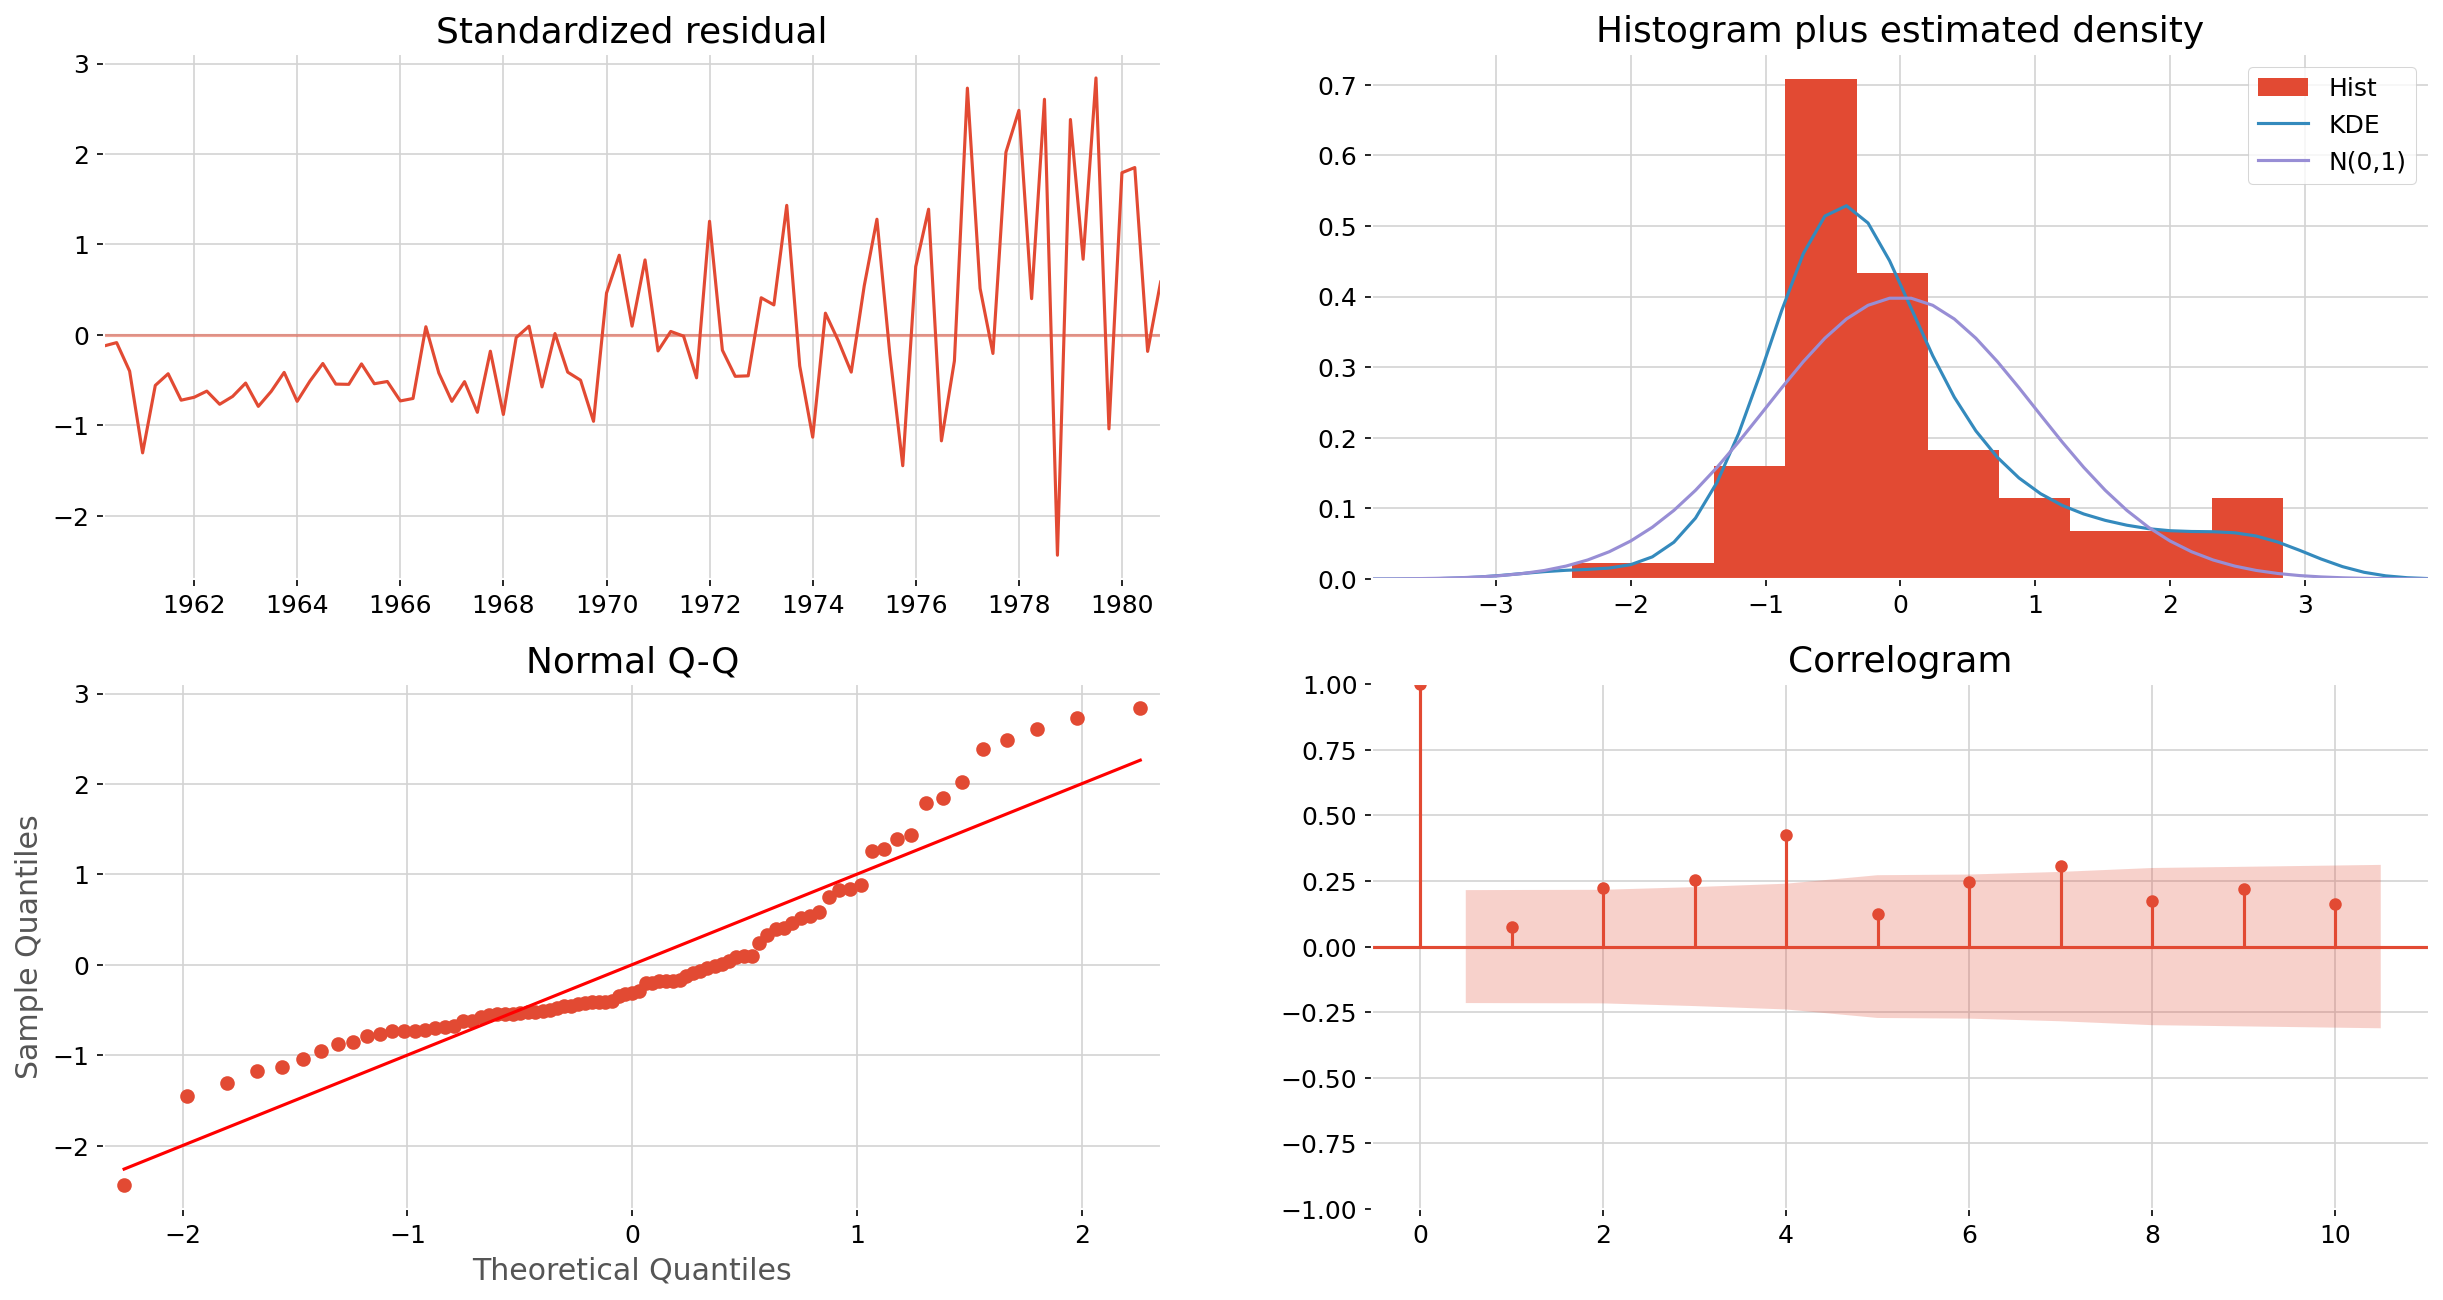

In [23]:
fit_arima.plot_diagnostics(figsize=(20,10));

In [24]:
best_model = SARIMAX(df_jjq['data'], order=(3,1,2), simple_differencing=False)
res = best_model.fit(disp=False)

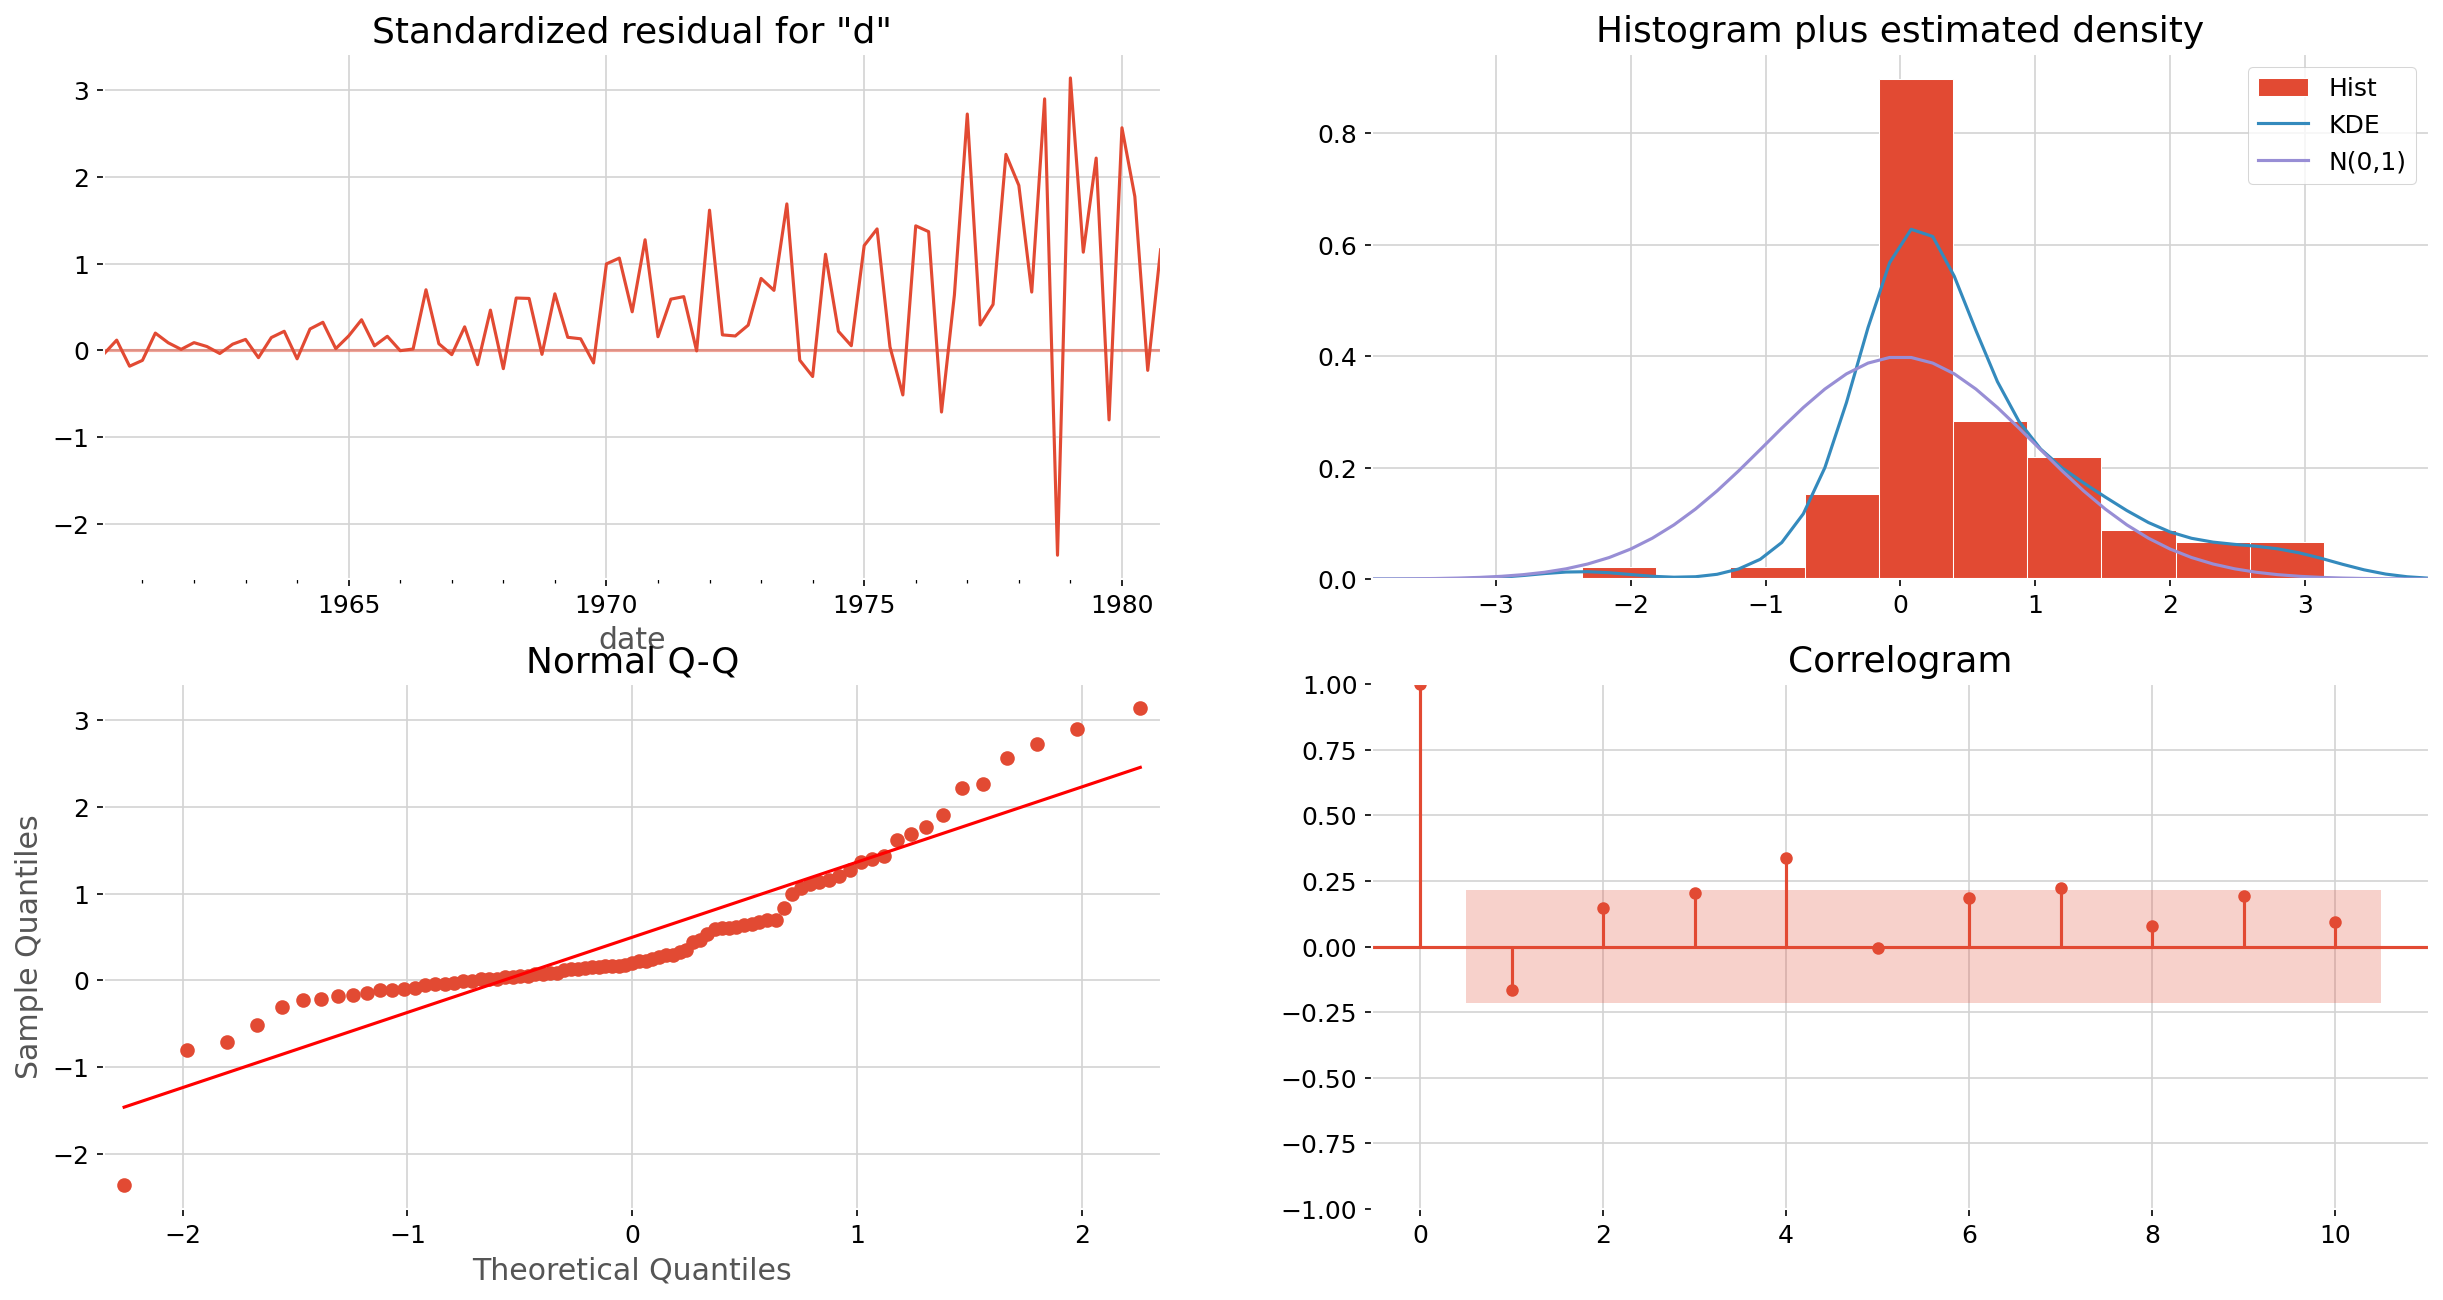

In [25]:
res.plot_diagnostics(figsize=(20,10));

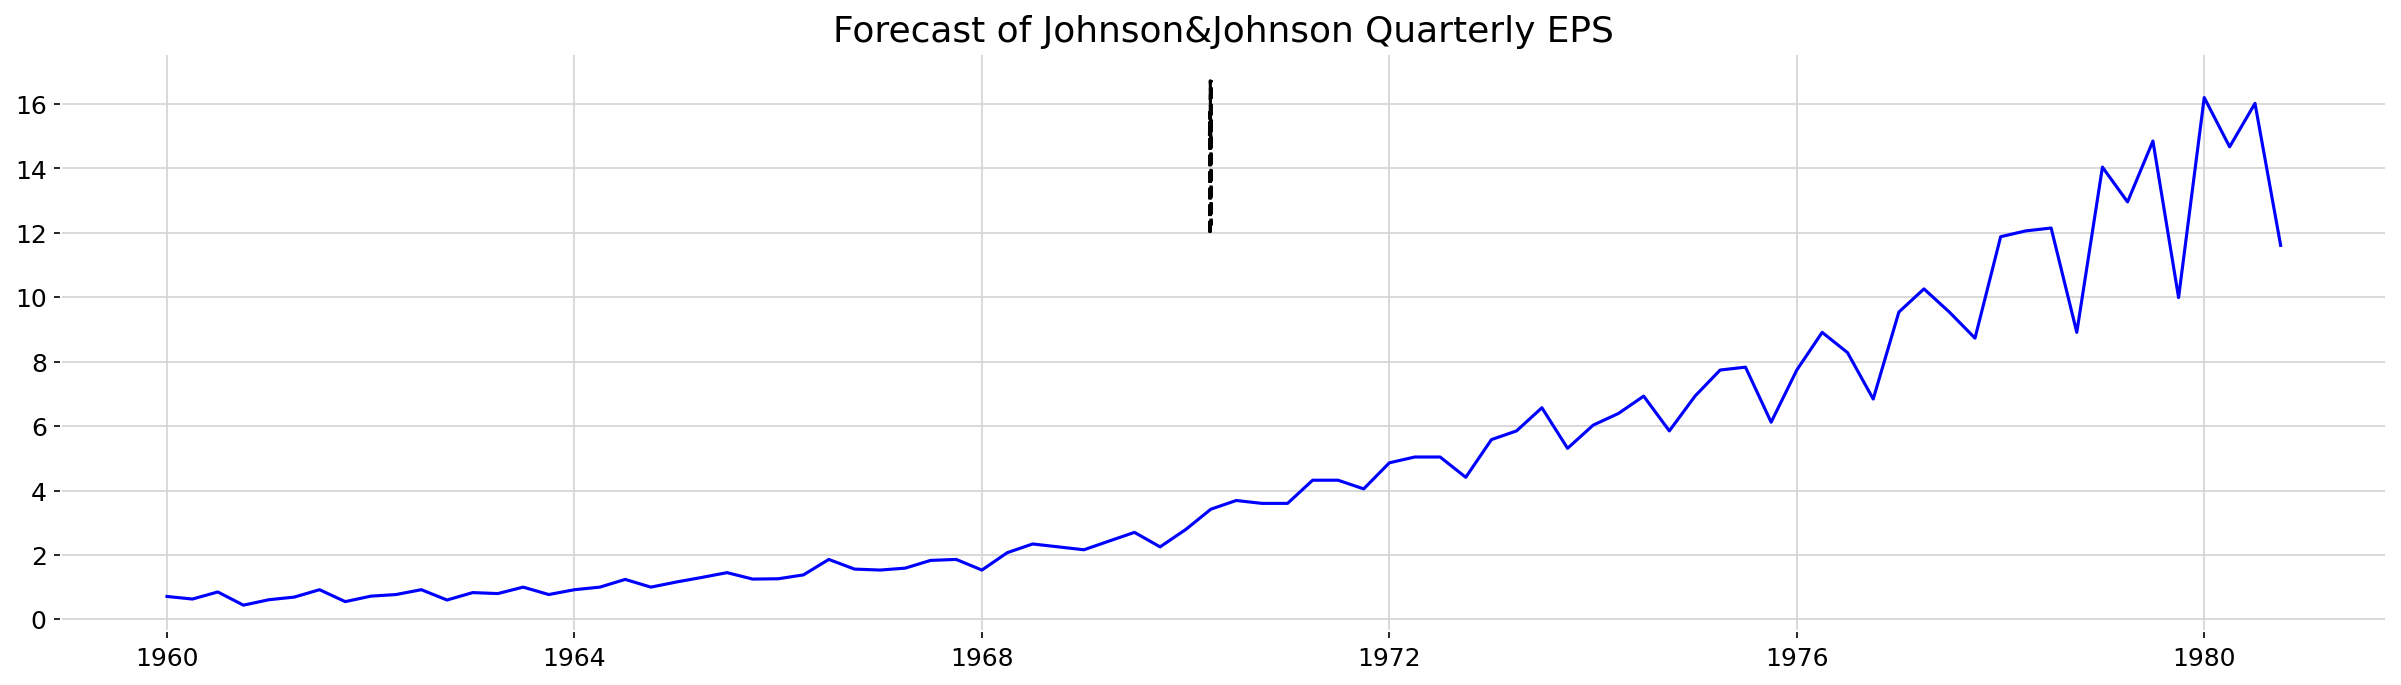

In [26]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(df_jjq['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Johnson&Johnson Quarterly EPS')
plt.show()